In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import signal
from scipy.optimize import curve_fit
import math
from typing import Optional 


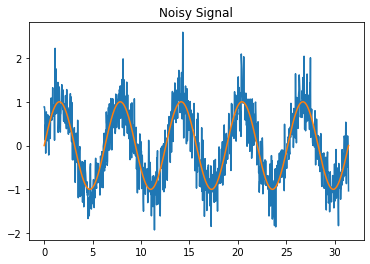

In [5]:
np.random.seed(123456789)
tspan =  np.linspace(0, 10*np.pi, 1000) 
teval = 0
Vin = lambda t: np.sin(t)
mynoise = 0.4*np.random.randn(*Vin(tspan).shape)
Vinarray = Vin(tspan) + mynoise

plt.plot(tspan, Vinarray)
plt.plot(tspan, Vin(tspan))
plt.title("Noisy Signal")
plt.show()

In [23]:
class Filters:
    def __init__(self, tspan, signal):
        self.tspan = tspan
        self.signal = signal
    
    #used to find nearest time index for RK45 integrator
    def find_nearest(self, array, value):
        idx = np.searchsorted(array, value, side="left")
        if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
            return idx-1
        else:
            return idx
        
#directly transferred from circuits        
class TimesteppedFilters(Filters):
    #returns function derivative at discrete points for timestepping(tspan)
    def __init__(self, tspan, signal):
        super().__init__(tspan, signal)
        
    def lowpassdisc(self, t, y, signal, tau):
        dydt = (1/tau)*(signal[self.find_nearest(self.tspan, t)]-y)
        return dydt
    
    def highpassdisc(self, t, y, signal, tau):
        dydt = (signal[self.find_nearest(self.tspan, t)]+
                signal[self.find_nearest(self.tspan, t)-1])/(self.tspan[self.find_nearest(self.tspan, t)]
                -self.tspan[self.find_nearest(self.tspan, t)-1])-y/tau
        return dydt       

    #integrators for filter equations
    def solvelow(self, tau):
        sol_low = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[self.signal, tau])
        return sol_low
    
    def solvehigh(self, tau):
        sol_high = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                             t_eval=self.tspan, args=[self.signal, tau])
        return sol_high
    
    def solvebandpass(self, tau1, tau2):
        lowpass = self.solvelow(tau1).y[0]
        bandpass = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], self.tspan[-1]],[0], 
                             t_eval=self.tspan, args=[lowpass, tau2])
        return bandpass

    #graphing filtered data
    def graph(self, sol, ftype, truth=None):
        plt.plot(sol.t, sol.y[0,:])
        if truth is not None:
            plt.plot(self.tspan, truth)
        plt.title("%s, Scipy RK45 Integrator" %ftype)
        plt.show()
        
#digital Butterworth Filters        
class ButterworthFilters(Filters):

    def __init__(self, tspan, signal):
        super().__init__(tspan, signal)  
        
    def lbutt(self, t, order, freq0):
        order = int(order)
        freqarray = np.empty(1)
        freqarray[0] = freq0
        b, a = signal.butter(order, freqarray, btype='lowpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def hbutt(self, t, order, freq0):
        order = int(order)
        freqarray = np.empty(1)
        freqarray[0] = freq0
        b, a = signal.butter(order, freqarray, btype='highpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def bpassbutt(self, t, order, freq0, freq1):
        order = int(order)
        freqarray = np.empty(2)
        freqarray[0] = freq0
        freqarray[1] = freq1
        b, a = signal.butter(order, freqarray, btype='bandpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def bstopbutt(self, t, order, freq0, freq1):
        order = int(order)
        freqarray = np.empty(2)
        freqarray[0] = freq0
        freqarray[1] = freq1
        b, a = signal.butter(order, freqarray, btype='bandstop')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)] 
   
    def optparams(self, orders, truth, ftype):
        if ftype=='lowpass':             
            popt, pcov = curve_fit(self.lbutt, self.tspan, truth, p0=[1, 0.5], bounds=(0, [np.inf, 0.99]))
            minerr = np.linalg.norm(truth-self.lbutt(self.tspan, *popt))
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.lbutt, self.tspan, truth, p0=[order, 0.5], bounds=(0, [np.inf, 0.99]))
                err = np.linalg.norm(truth-self.lbutt(self.tspan, *popt))
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.lbutt, self.tspan, truth, p0=[minorder, 0.5], bounds=(0, [np.inf, 0.99]))
            y = self.lbutt(self.tspan, *minpopt)
            return y, minpopt
            
        elif ftype=='highpass':  
            popt, pcov = curve_fit(self.hbutt, self.tspan, truth, p0=[1, 0.01], bounds=(0, [np.inf, 0.99]))
            minerr = np.linalg.norm(truth-self.hbutt(self.tspan, *popt))
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.hbutt, self.tspan, truth, p0=[order, 0.01], bounds=(0, [np.inf, 0.99]))
                err = np.linalg.norm(truth-self.hbutt(self.tspan, *popt))
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.hbutt, self.tspan, truth, p0=[minorder, 0.01], bounds=(0, [np.inf, 0.99]))
            y = self.hbutt(self.tspan, *minpopt)
            return y, minpopt                
           
        elif ftype=='bandpass':  
            popt, pcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[1, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
            minerr = np.linalg.norm(truth-self.bpassbutt(self.tspan, *popt))
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[order, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
                err = np.linalg.norm(truth-self.bpassbutt(self.tspan, *popt))
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[minorder, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
            y = self.bpassbutt(self.tspan, *minpopt)
            return y, minpopt 
        
        elif ftype=='bandstop':  
            popt, pcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[1, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
            minerr = np.linalg.norm(truth-self.bstopbutt(self.tspan, *popt))
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[order, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
                err = np.linalg.norm(truth-self.bstopbutt(self.tspan, *popt))
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[minorder, 0.01, 0.99], bounds=(0, [np.inf, 0.99, 0.99]))
            y = self.bstopbutt(self.tspan, *minpopt)
            return y, minpopt 
        
    def graph(self, y, popt, ftype, truth=None):
        plt.plot(self.tspan, y)
        if truth is not None:
            plt.plot(self.tspan, truth)
        if ftype=="Low Pass" or ftype=="High Pass":
            plt.title("Type: %s, Parameters: Order: %d, Critical Frequency: %f" %(ftype, int(popt[0]), popt[1]))
            plt.show()
        elif ftype=="Band Pass" or ftype=="Band Stop":
            plt.title("Type: %s, Parameters: Order: %d, Critical Frequencies: %f, %f" %(ftype, int(popt[0]), popt[1], popt[2]))
            plt.show()

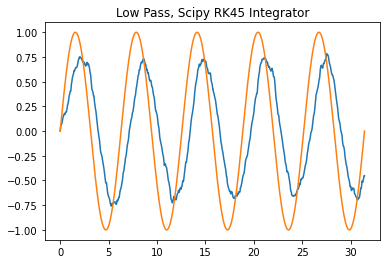

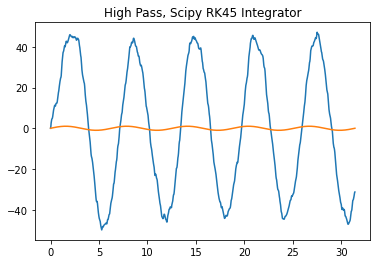

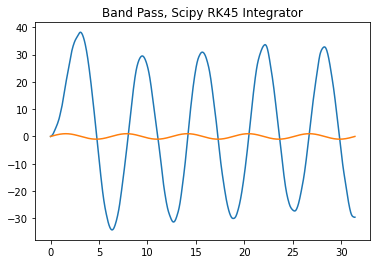

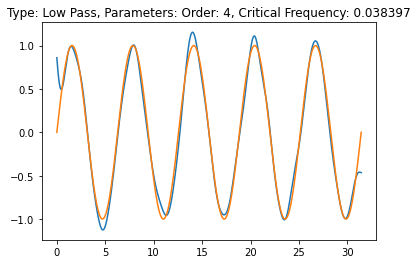

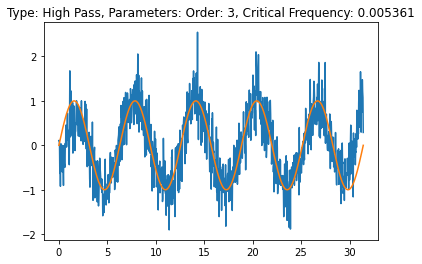

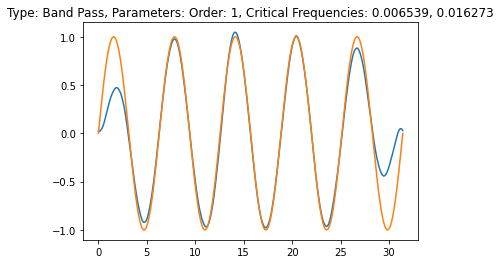

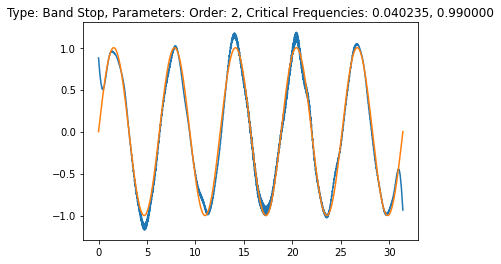

In [24]:
#Running filters and graphing
filtered = TimesteppedFilters(tspan, Vinarray)
lowfilter = filtered.solvelow(1)
filtered.graph(lowfilter, "Low Pass", Vin(tspan))

highfilter = filtered.solvehigh(1)
filtered.graph(highfilter, "High Pass", Vin(tspan))

bandpassfilter = filtered.solvebandpass(1,1)
filtered.graph(bandpassfilter, "Band Pass", Vin(tspan))

butterworth = ButterworthFilters(tspan, Vinarray)
butterlow = butterworth.optparams(10, Vin(tspan), ftype='lowpass')
butterworth.graph(butterlow[0], butterlow[1], "Low Pass", truth=Vin(tspan))

butterhigh = butterworth.optparams(10, Vin(tspan), ftype='highpass')
butterworth.graph(butterhigh[0], butterhigh[1], "High Pass", truth=Vin(tspan))

butterbpass = butterworth.optparams(10, Vin(tspan), ftype='bandpass')
butterworth.graph(butterbpass[0], butterbpass[1], "Band Pass", truth=Vin(tspan))

butterbstop = butterworth.optparams(10, Vin(tspan), ftype='bandstop')
butterworth.graph(butterbstop[0], butterbstop[1],"Band Stop", truth=Vin(tspan))
#b, a = scipy.signal.cheby1(1, 20, 0.2)
#y = scipy.signal.filtfilt(b, a, Vinarray)
#plt.plot(tspan,  y)

#b, a = scipy.signal.cheby2(1, 20, 0.2)
#y = scipy.signal.filtfilt(b, a, Vinarray)
#plt.plot(tspan, y)